Using 96 processes for image analysis.
Analyzing texture for class: 0


Processing Class 0: 100%|██████████| 134049/134049 [00:00<00:00, 4182696.58it/s]


Analyzing texture for class: 1


Processing Class 1: 100%|██████████| 528761/528761 [00:00<00:00, 3647179.78it/s]


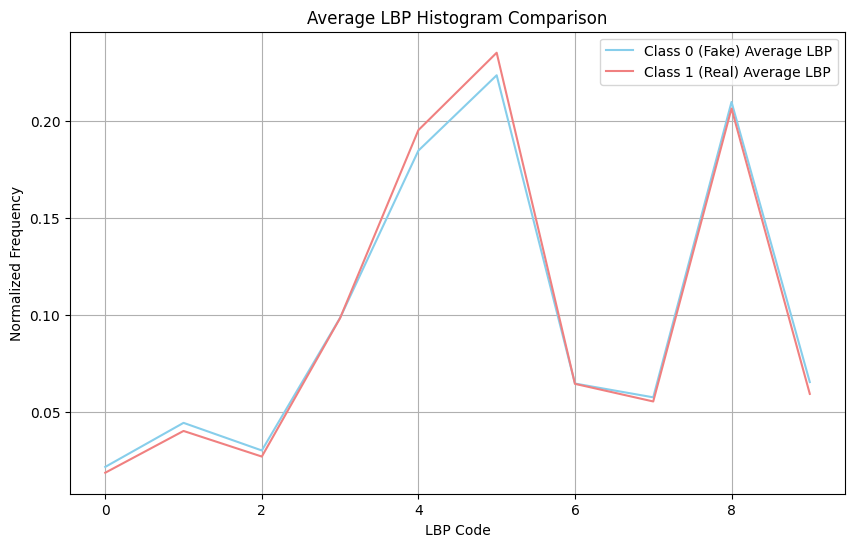

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from tqdm import tqdm
from multiprocessing import Pool, cpu_count # 导入multiprocessing模块

# --- LBP 处理的独立函数 ---
def process_single_image_lbp(img_path, n_points, radius):
    """
    处理单张图像并返回其LBP直方图。
    这个函数设计为在多进程池中运行。
    """
    try:
        img = cv2.imread(img_path)
        if img is None:
            # print(f"Could not read image: {img_path}") # 在进程中打印可能导致混乱
            return None
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 计算LBP
        lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')
        # 计算LBP直方图
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins))
        return hist
    except Exception as e:
        # print(f"Error processing {img_path}: {e}") # 在进程中打印可能导致混乱
        return None

# def analyze_texture_features_multithreaded(base_path="xinye10/train"):
base_path="xinye10/train"
lbp_histograms = {'0': [], '1': []}
radius = 1 # LBP算法的半径
n_points = 8 * radius # LBP的采样点数量

# 确定使用的进程数，通常是CPU核心数
num_processes = cpu_count()
print(f"Using {num_processes} processes for image analysis.")

for class_id in ['0', '1']:
    class_path = os.path.join(base_path, class_id)
    if not os.path.exists(class_path):
        print(f"Warning: Directory {class_path} not found. Skipping class {class_id}.")
        continue

    print(f"Analyzing texture for class: {class_id}")
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]
    # 构建任务列表
    tasks = [(os.path.join(class_path, img_name), n_points, radius) for img_name in image_files]

    # 使用进程池处理图像
    with Pool(processes=num_processes) as pool:
        # imap_unordered 可以在结果就绪时立即获取，对于进度条很有用
        # chunksize 可以调整，用于控制每次分配给进程的任务数量
        results = list(tqdm(pool.starmap(process_single_image_lbp, tasks), total=len(tasks), desc=f"Processing Class {class_id}"))

    # 收集结果
    for hist in results:
        if hist is not None:
            lbp_histograms[class_id].append(hist)
        # else:
        #     # 可以在这里记录失败的图片数量
        #     pass

# 平均LBP直方图
if lbp_histograms['0']:
    # 确保直方图的维度一致，因为一些图像可能导致不同的lbp.max()
    # 我们可以找到所有直方图的最大 bin 数量，并对较小的直方图进行填充
    max_bins_0 = max([len(h) for h in lbp_histograms['0']]) if lbp_histograms['0'] else 0
    padded_hists_0 = [np.pad(h, (0, max_bins_0 - len(h)), 'constant') for h in lbp_histograms['0']]
    avg_lbp_0 = np.mean(padded_hists_0, axis=0)
else:
    avg_lbp_0 = np.zeros(n_points + 2) # 如果没有数据，使用默认大小的零数组

if lbp_histograms['1']:
    max_bins_1 = max([len(h) for h in lbp_histograms['1']]) if lbp_histograms['1'] else 0
    padded_hists_1 = [np.pad(h, (0, max_bins_1 - len(h)), 'constant') for h in lbp_histograms['1']]
    avg_lbp_1 = np.mean(padded_hists_1, axis=0)
else:
    avg_lbp_1 = np.zeros(n_points + 2) # 如果没有数据，使用默认大小的零数组

# 绘制直方图时，需要确保x轴的范围匹配最大的直方图维度
max_overall_bins = max(len(avg_lbp_0), len(avg_lbp_1))

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(avg_lbp_0)), avg_lbp_0, label='Class 0 (Fake) Average LBP', color='skyblue')
plt.plot(np.arange(len(avg_lbp_1)), avg_lbp_1, label='Class 1 (Real) Average LBP', color='lightcoral')
plt.title('Average LBP Histogram Comparison')
plt.xlabel('LBP Code')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.grid(True)
plt.show()

# 运行分析
# analyze_texture_features_multithreaded()